# Full PolyA Prediction Pipeline

## Import

In [1]:
import os, csv, ast, subprocess
from pathlib import Path
import pickle
import pyfaidx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as ptc
from matplotlib.ticker import MultipleLocator

In [2]:
PROJECT   = os.path.abspath(os.path.join(".",""))
RESOURCES = os.path.join(PROJECT, "resources")
RESULTS   = os.path.join(PROJECT, "results")
OUTDIR = RESULTS
os.makedirs(OUTDIR, exist_ok=True)
MODEL_PATHS = {
  "polyaid":       Path("resources/published_models/PolyaID.h5"),
  "polyastrength": Path("resources/published_models/PolyaStrength.h5")
}
CODE_DIR = Path("code")
OUTDIR   = Path("results")
OUTDIR.mkdir(exist_ok=True, parents=True)

## Helper Function

In [3]:
def extractsequence(genome, chrom, start, end, strand):
    if strand == "+":
        sequence = genome[chrom][start:end].seq
    elif strand == "-":
        sequence = genome[chrom][start:end].reverse.complement.seq
    return sequence


def get_sequence(genome, chrom_sizes, chrom, position, strand):

    start = int(position - 120)
    end = int(position + 120)

    if (strand == "-"):
        start += 1
        end += 1

    if (start <= 0) | (end >= chrom_sizes[chrom]):
        raise ValueError(f'Requested input with interval {sequence_length}bp exceeds the chromosome size.')

    return extractsequence(genome, chrom, start, end, strand).upper()


In [4]:
def temp_generate_data(sequences):

    df = pd.DataFrame.from_dict({'Sequence' : sequences})
    data_idx = np.arange(len(df), dtype = np.int)

    allSequenceGenerator = {
            gen_id : iso.DataGenerator(
                idx,
                {
                    'df' : df
                },
                batch_size = len(idx),
                inputs = [
                    {
                        'id' : 'seq',
                        'source_type' : 'dataframe',
                        'source' : 'df',
                        'extractor' : lambda row,index: row['Sequence'].upper(),
                        'encoder' : iso.OneHotEncoder(seq_length = 240),
                        'dim' : (240,4),
                        'sparsify' : False,
                    },
                ],
                randomizers = [],
                shuffle = False,
                densify_batch_matrices = True,
                move_outputs_to_inputs = False
            )
            for gen_id, idx in [('predict', data_idx)]
        }
    return allSequenceGenerator


In [5]:
def whole_gene_classification(ax, region, inputs, reads_dict, nbins = None, binwidth = None, normalize = None, arrow_int = 1000):

    sequences, encodings, classprobs, cleavage_vecs, cleavage_ctrs, idx = inputs



    xs = np.arange(region['start'], region['end'], 1)
    gene_xs = np.arange(region['gene_start'], region['gene_end'], 1)
    reads = [reads_dict.get((region['strand'], region['chrom'], x), 0) for x in xs]

    if (nbins is not None):
        xs_agg, binsize = np.linspace(region['start'], region['end'], num = nbins, retstep = True)

    if (binwidth is not None):
        xs_agg = np.arange(region['start'], region['end'], binwidth)
        binsize = binwidth

    reads_agg = [sum([reads_dict.get((region['strand'], region['chrom'], x), 0) for x in range(int(math.ceil(p)),int(math.ceil(p+binsize)))]) for p in xs_agg]

    ax[0].bar(xs_agg, reads_agg, width = binsize)
    ax[0].text(x = 0.01, y = 0.9, s = f"{region['gene']}\n{region['chrom']} ({region['strand']})\n{region['gene_start']:,d}-{region['gene_end']:,d}", ha = 'left', va = 'top', transform = ax[0].transAxes)

    adj_classprobs = np.asarray(classprobs) - 0.5
    colormat=np.where(adj_classprobs < 0, 'C3','C0')

    ax[1].bar(xs, adj_classprobs, width = 1, color = colormat)
    ax[1].axhline(y = 0, color = 'black', linestyle = 'dashed', linewidth = 0.5)

    ax[1].set_ylim((-0.55,0.55))
    ax[1].set_yticks([-0.5, 0, 0.5])
    ax[1].set_yticklabels([0, 0.5, 1.0])


    ## plot gene diagram
    utr_height = 2
    coding_height = 4
#     gene_direction_marker = '4' if (region['strand'] == '+') else '3'
    gene_direction_marker = '4'

    ax[-1].plot([region['gene_start'], region['gene_end']], [0, 0], color = 'k', linewidth = 1)
    ax[-1].plot(gene_xs[0::arrow_int], [0]*len(gene_xs[0::arrow_int]), marker = gene_direction_marker, linewidth = 0, markersize = 7, color = 'k')

    for estart, eend in zip(region['exon_starts'], region['exon_ends']):

        if (estart < region['coding_start']):

            if (eend < region['coding_start']):
                
                gene_rect = ptc.Rectangle((estart, -utr_height/2), width = eend-estart, height = utr_height, color = 'k')
                ax[-1].add_patch(gene_rect)

            elif (eend >= region['coding_start']):

                gene_rect = ptc.Rectangle((estart, -utr_height/2), width = region['coding_start']-estart, height = utr_height, color = 'k')
                ax[-1].add_patch(gene_rect)

                gene_rect = ptc.Rectangle((region['coding_start'], -coding_height/2), width = eend-region['coding_start'], height = coding_height, color = 'k')
                ax[-1].add_patch(gene_rect)

        else:

            if (eend <= region['coding_end']):

                gene_rect = ptc.Rectangle((estart, -coding_height/2), width = eend-estart, height = coding_height, color = 'k')
                ax[-1].add_patch(gene_rect)

            else:

                if (estart <= region['coding_end']):

                    gene_rect = ptc.Rectangle((estart, -coding_height/2), width = region['coding_end']-estart, height = coding_height, color = 'k')
                    ax[-1].add_patch(gene_rect)

                    gene_rect = ptc.Rectangle((region['coding_end'], -utr_height/2), width = eend-region['coding_end'], height = utr_height, color = 'k')
                    ax[-1].add_patch(gene_rect)

                else:

                    gene_rect = ptc.Rectangle((estart, -utr_height/2), width = eend-estart, height = utr_height, color = 'k')
                    ax[-1].add_patch(gene_rect)

    ax[-1].get_yaxis().set_visible(False)
    ax[-1].set_frame_on(False)
    ax[-1].set_xticks([])
    ax[-1].set_xticklabels([])
    
    ## Reverse axis if the example gene is on the negative strand
    if (region['strand'] == '-'):
        for a in ax:
            a.xaxis.set_inverted(True)

    return


In [6]:
def cleavage_profile_explanation(ax, region, inputs, reads_dict, genome, visible_region = None, visible_labels = None, cutoff_class = 0.5, cutoff_clv = 0.05, background = 0.02, normalize = False, ylims_3reads = None, ylims_clv = None, ylims_pro = None):

    sequences, encodings, classprobs, cleavage_vecs, cleavage_ctrs, idx = inputs

    if (visible_region is None):
        visible_region = (region['start'], region['end'])

    idxs = np.arange(0, region['end'] - region['start'], 1)
    xs   = np.arange(region['start'], region['end'], 1)

    subset_idxs = idxs[np.where((xs >= visible_region[0]) & (xs < visible_region[1]))]
    subset_xs   = xs[subset_idxs]

    reads = np.asarray([reads_dict.get((region['strand'], region['chrom'], x), 0) for x in xs])

    class_idx = []
    class_clv_idx = []
    cleavage_cols = []

    for i,x in zip(subset_idxs, subset_xs):

        if (classprobs[i] > cutoff_class):
            class_idx.append(i)

            if (cleavage_ctrs[i] > cutoff_clv):
                p = ax[2].plot(np.arange(x-25,x+25,1), cleavage_vecs[i], linewidth = 0.5, alpha = 0.50, zorder = 2)
                pcolor = p[-1].get_color()
                cleavage_cols.append(pcolor)
                class_clv_idx.append(i)

            else:
                ax[2].plot(np.arange(x-25,x+25,1), cleavage_vecs[i], linewidth = 0.25, alpha = 0.05, color = 'gray', zorder = 1)

    class_idx     = np.asarray(class_idx)
    class_clv_idx = np.asarray(class_clv_idx)
    cleavage_cols = np.asarray(cleavage_cols)


    ## plot known 3'READS
    ax[0].bar(subset_xs, reads[subset_idxs], width = 2, color = 'gray')
    
    ax[0].yaxis.set_major_locator(MultipleLocator(ylims_3reads[1]))
    ax[0].set_ylim(ylims_3reads)


    ## plot classification predictions
    adj_classprobs = np.asarray(classprobs) - 0.5
    colormat=np.where(adj_classprobs < 0, 'C0','C3')

    ax[1].bar(subset_xs, adj_classprobs[subset_idxs], width = 1, color = colormat[subset_idxs])
    ax[1].axhline(y = 0, color = 'black', linestyle = 'dashed', linewidth = 0.5)

    ax[1].set_ylim((-0.55,0.55))
    ax[1].set_yticks([-0.5, 0.5])
    ax[1].set_yticklabels([0, 1.0])

    ax[1].yaxis.set_minor_locator(MultipleLocator(0.5))


    # ## plot cleavage vector predictions
    # ax[2].scatter(xs[class_idx], cleavage_ctrs[class_idx], color = cleavage_cols, s = 3, zorder = 2)

    ## plot cleavage vectors passing thresholds to generate cleavage profile
    ax[2].axhline(y = 0.05, color = 'black', linestyle = 'dashed', linewidth = 0.5)
    ax[2].scatter(xs[class_clv_idx], cleavage_ctrs[class_clv_idx], color = cleavage_cols, s = 2, zorder = 3)

    ax[2].yaxis.set_major_locator(MultipleLocator(ylims_clv[1]))
    ax[2].set_ylim(ylims_clv)


    ## plot mean cleavage profile
    pred_dict = dict(zip(xs[class_clv_idx], cleavage_vecs[class_clv_idx]))
    cleavage_profs = []

    for pos in subset_xs:

        pstart, pend = (pos-25, pos+25)
        results = [(p, pred_dict.get(p)) for p in range(pstart+1,pend) if (p in pred_dict)]

        if (len(results) > 0):
            starts, cleavages = list(zip(*results))
            positive_arr = np.zeros((len(results),))

            for i, (ostart, ocleavage) in enumerate(zip(starts, cleavages)):
                odict = dict(zip(list(range(ostart-25,ostart+25)), ocleavage))
                positive_arr[i,] = odict[pos]

            outmean = np.mean(positive_arr, axis = 0)

            if (outmean > background):
                cleavage_profs.append(outmean - background)
            else:
                cleavage_profs.append(0)

        else:
            cleavage_profs.append(0)

    cleavage_profs = np.asarray(cleavage_profs)

    if (normalize) and (np.sum(cleavage_profs) > 0):
        cleavage_profs = cleavage_profs / np.sum(cleavage_profs)

    ax[3].plot(subset_xs, cleavage_profs, linewidth = 0.5, color = 'gray')

    ax[3].yaxis.set_major_locator(MultipleLocator(ylims_pro[1]))
    ax[3].set_ylim(ylims_pro)


    ## plot representative sites from whole genome analysis if available
    ## otherwise plot the maximum site of the cleavage profile track
    
    if ('repr_sites' in region):
        
        clv_idx = np.where(np.isin(subset_xs, region['repr_sites']))
        clv_xs  = subset_xs[clv_idx]
        clv_pro = cleavage_profs[clv_idx]
        
        ax[4].bar(clv_xs, clv_pro, width = 1.2, color = 'gray')
        outputs = (clv_xs, clv_pro)
        
    else:

        cleavage_max_idx = np.argmax(cleavage_profs)
        ax[4].bar(subset_xs[cleavage_max_idx], cleavage_profs[cleavage_max_idx], width = 1.2, color = 'gray')
        outputs = ([subset_xs[cleavage_max_idx]], [cleavage_profs[cleavage_max_idx]])

    ax[4].yaxis.set_major_locator(MultipleLocator(ylims_pro[1]))
    ax[4].set_ylim(ylims_pro)


    if (visible_labels is not None):

        ax[0].set_xlim(visible_region)

        if (visible_labels == 'relative'):

            ax[0].set_xticks(np.arange(visible_region[0], visible_region[1]+1, 100))
            ax[0].set_xticklabels(np.arange(-1 *(visible_region[1]-visible_region[0])/2, 1+(visible_region[1]-visible_region[0])/2, 100, dtype = int))

            ax[0].xaxis.set_minor_locator(MultipleLocator(25))

        else:

            ax[0].xaxis.set_major_locator(MultipleLocator(100))
            ax[0].xaxis.set_minor_locator(MultipleLocator(25))


    ## Remove spines from top and right edges of plot
    ## Reverse axis if the example gene is on the negative strand
    for a in ax:
        
        a.spines['right'].set_visible(False)
        a.spines['top'].set_visible(False)
        
        if (region['strand'] == '-'):
            a.xaxis.set_inverted(True)

    return outputs


In [7]:
def run_predictions(windows_txt: Path, outdir: Path, codedir: Path, model_paths: dict):
    merged = outdir / f"{windows_txt.stem}.comprehensive_predictions.txt"
    # run each model
    for mtype, mpath in model_paths.items():
        print(f"[Predict] {mtype} …")
        proc = subprocess.run([
            "python3", str(codedir/"example.prediction.py"),
            "--model",      str(mpath),
            "--modeltype",  mtype,
            "--data",       str(windows_txt),
            "--dataname",   windows_txt.stem,
            "--outdir",     str(outdir)
        ], capture_output=True, text=True)
        print(proc.stdout, proc.stderr, sep="\n")
        proc.check_returncode()
    # merge
    p1 = outdir/f"{windows_txt.stem}.predictions_polyaid.txt"
    p2 = outdir/f"{windows_txt.stem}.predictions_polyastrength.txt"
    with open(merged, "w") as out, open(p1) as a, open(p2) as b:
        h1 = a.readline().rstrip().split("\t")
        h2 = b.readline().rstrip().split("\t")
        out.write("\t".join(h1[:9] + h2[-2:]) + "\n")
        for l1, l2 in zip(a, b):
            c1, c2 = l1.rstrip().split("\t"), l2.rstrip().split("\t")
            out.write("\t".join(c1[:9] + c2[-2:]) + "\n")
    return merged

In [8]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


## MODEL PARAMETERS

input_shape               = (240,4)

polyaid_bin_len           = 1
polyaid_bin_dropout       = 0.7
polyaid_vec_len           = 50
polyaid_vec_dropout       = 0.1

polyastrength_bin_len     = 1
polyastrength_bin_dropout = 0.1



## HELPER FUNCTIONS

def load_genome(genome_path):
	'''Loads searchable and indexed genome from absolute path for genome FASTA file.
	'''

	import pyfaidx
	return pyfaidx.Fasta(genome_path, sequence_always_upper=True)



def get_chrom_size(chrom_size_path):
	'''Creates dictionary of chromosome sizes in nucleotides.
	'''

	chrom_dict = {}

	with open(chrom_size_path, mode = 'r') as infile:
		for line in infile:
			entries = line.strip("\n").split("\t")
			chrom_dict[entries[0]] = int(entries[1])

	return chrom_dict



def extract_sequence(genome, chrom, start, end, strand):
	'''Use genomic coordinates and indexed genome to extract the genomic sequence for the indicated interval.
	'''

	sequence = genome[chrom][start:end]

	if (strand == "+"):
		return sequence.seq.upper()
	elif (strand == '-'):
		return sequence.reverse.complement.seq.upper()



def get_window(genome, chrom_sizes, chrom, position, strand):
	'''Fetches 240 nt genomic sequence surrounding the indicated position.
	'''
	
	start = int(position - 120)
	end = int(position + 120)

	if (start <= 0) | (end >= chrom_sizes[chrom]):
		raise ValueError(f'Requested input with interval at ({chrom}:{start}-{end}:{strand}) exceeds the chromosome edges.')

	## if on the reverse strand, shift the coordinates one to put the position of interest at the 120th index in the sequence

	if (strand == '-'):
		start += 1
		end += 1

	return extract_sequence(genome, chrom, start, end, strand).upper()



## CONSTRUCT MODELS AND INPUT DATA

def make_polyaid_model(model_path):
	'''Builds the PolyaID model and loads the trained weights.
	'''

	from contextlib import redirect_stderr

	with redirect_stderr(open(os.devnull, "w")):

		from keras import Input
		from keras.models import Model
		from keras.layers import Dense, Dropout, Flatten, Bidirectional
		from keras.layers import Conv1D, MaxPooling1D, LSTM
		from keras.activations import sigmoid
		from keras.layers import ReLU
		from keras import backend as K

	import tensorflow as tf
	tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
	
	model_input = Input(shape = input_shape)
	
	x = ReLU()(Conv1D(512, 8, padding = 'valid', strides = 1, name = 'bin_conv')(model_input))
	x = MaxPooling1D(pool_size = 3, strides = 3, name = 'bin_pool')(x)
	x = Dropout(polyaid_bin_dropout)(x)
	x = Bidirectional(LSTM(units = 128, return_sequences = True, name = 'bin_lstm'))(x)
	x = Dropout(polyaid_bin_dropout)(x)
	x = Flatten(name = 'bin_flatten')(x)
		
	bin_x = ReLU()(Dense(256, kernel_initializer = 'glorot_uniform', name = 'bin_dense1')(x))
	bin_x = Dropout(polyaid_bin_dropout)(bin_x)
	bin_x = ReLU()(Dense(256, kernel_initializer = 'glorot_uniform', name = 'bin_dense2')(bin_x))
	bin_x = Dropout(polyaid_bin_dropout)(bin_x)
	bin_x = ReLU()(Dense(128, kernel_initializer = 'glorot_uniform', name = 'bin_dense3')(bin_x))
	bin_x = Dropout(polyaid_bin_dropout)(bin_x)
	bin_x = ReLU()(Dense(64, name = 'bin_dense4')(bin_x))
	bin_x = Dense(polyaid_bin_len, activation = 'sigmoid', name = 'bin_predictions')(bin_x)
		
	prob_x = ReLU()(Dense(256, kernel_initializer = 'glorot_uniform', name = 'prob_dense1')(x))
	prob_x = Dropout(polyaid_vec_dropout)(prob_x)
	prob_x = ReLU()(Dense(256, kernel_initializer = 'glorot_uniform', name = 'prob_dense2')(prob_x))
	prob_x = Dropout(polyaid_vec_dropout)(prob_x)
	prob_x = ReLU()(Dense(128, kernel_initializer = 'glorot_uniform', name = 'prob_dense3')(prob_x))
	prob_x = Dropout(polyaid_vec_dropout)(prob_x)
	prob_x = ReLU()(Dense(64, name = 'prob_dense4')(prob_x))
	prob_x = Dense(polyaid_vec_len, activation = 'softmax', kernel_initializer = 'zeros', name = 'prob_predictions')(prob_x)
	
	model = Model(inputs = [model_input], outputs = [bin_x, prob_x], name = 'model')
	model.load_weights(model_path)
		
	return model



def make_polyastrength_model(model_path):
	'''Builds the PolyaStrength model and loads the trained weights.
	'''

	from contextlib import redirect_stderr

	with redirect_stderr(open(os.devnull, "w")):

		from keras import Input
		from keras.models import Model
		from keras.layers import Dense, Dropout, Flatten, Bidirectional
		from keras.layers import Conv1D, MaxPooling1D, LSTM
		from keras.layers import ReLU	
		from keras import backend as K

	import tensorflow as tf
	tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

	model_input = Input(shape = input_shape)

	x = ReLU()(Conv1D(64, 8, padding = 'valid', strides = 1, name = 'seq_conv')(model_input))
	x = MaxPooling1D(pool_size = 3, strides = 3, name = 'bin_pool')(x)
	x = Dropout(polyastrength_bin_dropout)(x)
	x = Bidirectional(LSTM(units = 16, return_sequences = True, name = 'bin_lstm'))(x)
	x = Dropout(polyastrength_bin_dropout)(x)
	x = Flatten(name = 'bin_flatten')(x)
	
	bin_x = ReLU()(Dense(128, kernel_initializer = 'glorot_uniform', name = 'bin_dense1')(x))
	bin_x = Dropout(polyastrength_bin_dropout)(bin_x)
	bin_x = ReLU()(Dense(64, name = 'bin_dense2')(bin_x))
	bin_x = Dense(polyastrength_bin_len, activation = 'linear', name = 'bin_predictions')(bin_x)
	
	model = Model(inputs = model_input, outputs = bin_x, name = 'model')
	model.load_weights(model_path)
	
	return model



def generate_data(sequences):
	'''Prepares data generator to flow data into the models for prediction.
	'''

	import numpy as np
	import pandas as pd
	import isolearn.keras as iso

	if (isinstance(sequences, str)):
		sequences = [sequences]

	df = pd.DataFrame.from_dict({'Sequence' : sequences})
	data_idx = np.arange(len(df), dtype = int)
	
	allSequenceGenerator = {
			gen_id : iso.DataGenerator(
				idx,
				{
					'df' : df
				},
				batch_size = len(idx),
				inputs = [
					{
						'id'          : 'seq',
						'source_type' : 'dataframe',
						'source'      : 'df',
						'extractor'   : lambda row,index: row['Sequence'].upper(),
						'encoder'     : iso.OneHotEncoder(seq_length = input_shape[0]),
						'dim'         : input_shape,
						'sparsify'    : False,
					},
				],
				randomizers = [],
				shuffle = False,
				densify_batch_matrices = True,
				move_outputs_to_inputs = False
			)
			for gen_id, idx in [('predict', data_idx)]
		}
	return allSequenceGenerator




In [9]:
def get_sliding_windows(genome, chrom_sizes, chrom, position, strand, total_length):
	'''Returns multiple 240 nt windows sliding by 1 nt from a longer region (e.g., 300 nt).
	'''

	start = int(position - total_length // 2)
	end = int(position + total_length // 2)

	if (strand == '-'):
		start += 1
		end += 1

	if start < 0 or end > chrom_sizes[chrom]:
		raise ValueError(f"Interval {chrom}:{start}-{end}:{strand} out of bounds.")

	full_seq = extract_sequence(genome, chrom, start, end, strand).upper()
	
	windows = [full_seq[i:i+240] for i in range(len(full_seq) - 240 + 1)]

	return windows


In [10]:
def save_sliding_windows(sequence, output_path):
	'''Save sliding windows with fixed chrom, start=0, end=0, strand=+, and 240nt sequence per row.'''

	chrom = "chrom"
	strand = "+"
	start = 0
	end = 0

	with open(output_path, 'w') as f:
		f.write("chrom\tstart\tend\tstrand\tsequence\n")
		for i in range(len(sequence) - 240 + 1):
			window_seq = sequence[i:i+240]
			f.write(f"{chrom}\t{start}\t{end}\t{strand}\t{window_seq}\n")


In [11]:
def run_predictions2(windows_txt: Path, outdir: Path, codedir: Path, model_paths: dict):
    merged = outdir / "comprehensive_predictions.txt"
    # run each model
    for mtype, mpath in model_paths.items():
        print(f"[Predict] {mtype} …")
        proc = subprocess.run([
            "python3", str(codedir/"example.prediction.py"),
            "--model",      str(mpath),
            "--modeltype",  mtype,
            "--data",       str(windows_txt),
            "--dataname",   "seq",
            "--outdir",     str(outdir)
        ], capture_output=True, text=True)
        print(proc.stdout, proc.stderr, sep="\n")
        proc.check_returncode()
    # merge
    p1 = outdir/"seq.predictions_polyaid.txt"
    p2 = outdir/"seq.predictions_polyastrength.txt"
    with open(merged, "w") as out, open(p1) as a, open(p2) as b:
        h1 = a.readline().rstrip().split("\t")
        h2 = b.readline().rstrip().split("\t")
        out.write("\t".join(h1[:9] + h2[-2:]) + "\n")
        for l1, l2 in zip(a, b):
            c1, c2 = l1.rstrip().split("\t"), l2.rstrip().split("\t")
            out.write("\t".join(c1[:9] + c2[-2:]) + "\n")
    return merged

In [12]:
def cleavage_profile_explanation2(ax, region, inputs, reads_dict, genome,
    visible_region=None, visible_labels=None, cutoff_class=0.5, cutoff_clv=0.05,
    background=0.02, normalize=False, ylims_3reads=None, ylims_clv=None, ylims_pro=None):

    sequences, encodings, classprobs, cleavage_vecs, cleavage_ctrs, idx = inputs

    n = len(classprobs)                              # number of windows
    if visible_region is None:
        visible_region = (region['start'], region['start'] + n)

    xs   = np.arange(region['start'], region['start'] + n, 1)
    idxs = np.arange(n)

    subset_mask = (xs >= visible_region[0]) & (xs < visible_region[1])
    subset_idxs = idxs[subset_mask]
    subset_xs   = xs[subset_mask]

    reads = np.asarray([reads_dict.get((region['strand'], region['chrom'], x), 0) for x in xs])

    class_idx = []
    class_clv_idx = []
    cleavage_cols = []

    for i,x in zip(subset_idxs, subset_xs):

        if (classprobs[i] > cutoff_class):
            class_idx.append(i)

            if (cleavage_ctrs[i] > cutoff_clv):
                p = ax[2].plot(np.arange(x-25,x+25,1), cleavage_vecs[i], linewidth = 0.5, alpha = 0.50, zorder = 2)
                pcolor = p[-1].get_color()
                cleavage_cols.append(pcolor)
                class_clv_idx.append(i)

            else:
                ax[2].plot(np.arange(x-25,x+25,1), cleavage_vecs[i], linewidth = 0.25, alpha = 0.05, color = 'gray', zorder = 1)

    class_idx     = np.asarray(class_idx)
    class_clv_idx = np.asarray(class_clv_idx)
    cleavage_cols = np.asarray(cleavage_cols)


    ## plot known 3'READS
    ax[0].bar(subset_xs, reads[subset_idxs], width = 2, color = 'gray')
    
    ax[0].yaxis.set_major_locator(MultipleLocator(ylims_3reads[1]))
    ax[0].set_ylim(ylims_3reads)


    ## plot classification predictions
    adj_classprobs = np.asarray(classprobs) - 0.5
    colormat=np.where(adj_classprobs < 0, 'C0','C3')

    ax[1].bar(subset_xs, adj_classprobs[subset_idxs], width = 1, color = colormat[subset_idxs])
    ax[1].axhline(y = 0, color = 'black', linestyle = 'dashed', linewidth = 0.5)

    ax[1].set_ylim((-0.55,0.55))
    ax[1].set_yticks([-0.5, 0.5])
    ax[1].set_yticklabels([0, 1.0])

    ax[1].yaxis.set_minor_locator(MultipleLocator(0.5))


    # ## plot cleavage vector predictions
    # ax[2].scatter(xs[class_idx], cleavage_ctrs[class_idx], color = cleavage_cols, s = 3, zorder = 2)

    ## plot cleavage vectors passing thresholds to generate cleavage profile
    ax[2].axhline(y = 0.05, color = 'black', linestyle = 'dashed', linewidth = 0.5)
    ax[2].scatter(xs[class_clv_idx], cleavage_ctrs[class_clv_idx], color = cleavage_cols, s = 2, zorder = 3)

    ax[2].yaxis.set_major_locator(MultipleLocator(ylims_clv[1]))
    ax[2].set_ylim(ylims_clv)

    ## plot mean cleavage profile
    pred_dict = dict(zip(xs[class_clv_idx], cleavage_vecs[class_clv_idx]))
    cleavage_profs = []

    for pos in subset_xs:

        pstart, pend = (pos-25, pos+25)
        results = [(p, pred_dict.get(p)) for p in range(pstart+1,pend) if (p in pred_dict)]

        if (len(results) > 0):
            starts, cleavages = list(zip(*results))
            positive_arr = np.zeros((len(results),))

            for i, (ostart, ocleavage) in enumerate(zip(starts, cleavages)):
                odict = dict(zip(list(range(ostart-25,ostart+25)), ocleavage))
                positive_arr[i,] = odict[pos]

            outmean = np.mean(positive_arr, axis = 0)

            if (outmean > background):
                cleavage_profs.append(outmean - background)
            else:
                cleavage_profs.append(0)

        else:
            cleavage_profs.append(0)

    cleavage_profs = np.asarray(cleavage_profs)

    if (normalize) and (np.sum(cleavage_profs) > 0):
        cleavage_profs = cleavage_profs / np.sum(cleavage_profs)

    ax[3].plot(subset_xs, cleavage_profs, linewidth = 0.5, color = 'gray')

    ax[3].yaxis.set_major_locator(MultipleLocator(ylims_pro[1]))
    ax[3].set_ylim(ylims_pro)


    ## plot representative sites from whole genome analysis if available
    ## otherwise plot the maximum site of the cleavage profile track
    
    if ('repr_sites' in region):
        
        clv_idx = np.where(np.isin(subset_xs, region['repr_sites']))
        clv_xs  = subset_xs[clv_idx]
        clv_pro = cleavage_profs[clv_idx]
        
        ax[4].bar(clv_xs, clv_pro, width = 1.2, color = 'gray')
        outputs = (clv_xs, clv_pro)
        
    else:

        cleavage_max_idx = np.argmax(cleavage_profs)
        ax[4].bar(subset_xs[cleavage_max_idx], cleavage_profs[cleavage_max_idx], width = 1.2, color = 'gray')
        outputs = ([subset_xs[cleavage_max_idx]], [cleavage_profs[cleavage_max_idx]])

    ax[4].yaxis.set_major_locator(MultipleLocator(ylims_pro[1]))
    ax[4].set_ylim(ylims_pro)


    if (visible_labels is not None):

        ax[0].set_xlim(visible_region)

        if (visible_labels == 'relative'):

            ax[0].set_xticks(np.arange(visible_region[0], visible_region[1]+1, 100))
            ax[0].set_xticklabels(np.arange(-1 *(visible_region[1]-visible_region[0])/2, 1+(visible_region[1]-visible_region[0])/2, 100, dtype = int))

            ax[0].xaxis.set_minor_locator(MultipleLocator(25))

        else:

            ax[0].xaxis.set_major_locator(MultipleLocator(100))
            ax[0].xaxis.set_minor_locator(MultipleLocator(25))


    ## Remove spines from top and right edges of plot
    ## Reverse axis if the example gene is on the negative strand
    for a in ax:
        
        a.spines['right'].set_visible(False)
        a.spines['top'].set_visible(False)
        
        if (region['strand'] == '-'):
            a.xaxis.set_inverted(True)

    return outputs


## Data

In [13]:
genome = pyfaidx.Fasta(os.path.join(RESOURCES, "hg38.genome.fa"))

chrom_sizes = {}
with open(os.path.join(RESOURCES, "hg38.chrom.sizes"), mode = 'r') as infile:
    for line in infile:
        entries = line.strip("\n").split("\t")
        chrom_sizes[entries[0]] = int(entries[1])
reads_dict = {}
#with open(os.path.join(RESOURCES, "reads3_scoring_dictionary.pickle"), mode = 'rb') as handle:
    #reads_dict = pickle.load(handle)

FastaNotFoundError: Cannot read FASTA from file /Users/tianzechen/Desktop/PolyaModelsHuman/resources/hg38.genome.fa

## Run prediction and plot

### Input is txt file

In [14]:
regions = pd.read_csv(
    "regions.txt",
    sep="\t",
    converters={
      "exon_starts": ast.literal_eval,
      "exon_ends":   ast.literal_eval
    }
)

[Predict] polyaid …

/Users/tianzechen/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
INFO:root:Recording results to: results/cntnap2_0.windows.predictions_polyaid.txt
DEBUG:h5py._conv:Creating converter from 3 to 5
INFO:root:Model loaded from: resources/published_models/PolyaID.h5
INFO:root:Making batch predictions for compiled input data: sequences=879.
INFO:root:Predictions complete, recording results.

Recording predictions: 0it [00:00, ?it/s]
Recording predictions: 879it [00:00, 27783.96it/s]

[Predict] polyastrength …

/Users/tianzechen/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/30

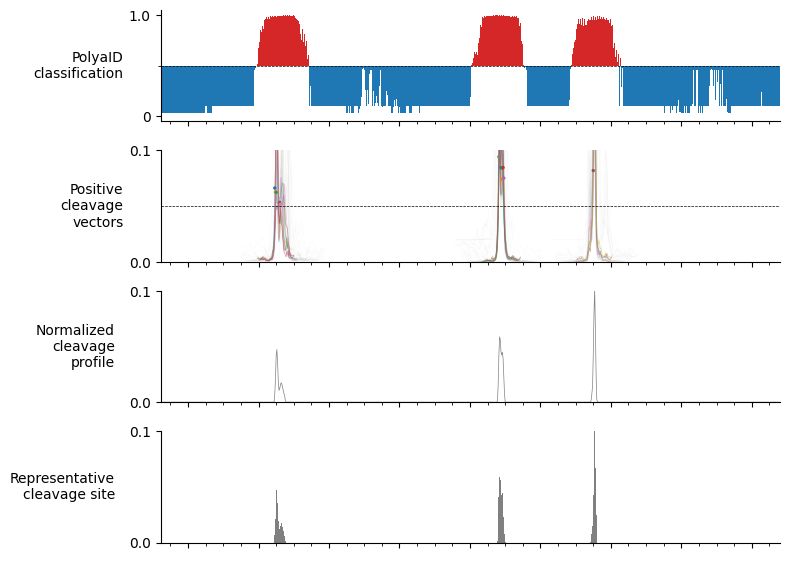

plotted CNTNAP2 (row 0) → results/profile_CNTNAP2_0.pdf


In [36]:
for i, row in regions.iterrows():
    gene, chrom, strand = row.gene, row.chrom, row.strand
    start0, end0 = int(row.start), int(row.end)
    region_start = start0 - 120
    region_end   = end0   + 120

    # 240-nt windows
    win_txt = OUTDIR/f"{gene.lower()}_{i}.windows.txt"
    with open(win_txt, "w") as W:
        W.write("chrom\tstart\tend\tstrand\tsequence\n")
        for pos in range(region_start, region_end):
            seq240 = get_sequence(genome, chrom_sizes, chrom, pos, strand)
            W.write(f"{chrom}\t{pos}\t{pos+1}\t{strand}\t{seq240}\n")

    #run merge predictions
    merged = run_predictions(win_txt, OUTDIR, CODE_DIR, MODEL_PATHS)
    examples = []
    with open(merged, newline="") as FH:
        reader = csv.DictReader(FH, delimiter="\t")
        for R in reader:
            R["start"]          = int(R["start"])
            R["classification"] = float(R["classification"])
            R["strength"]       = float(R.get("pred_logit", R.get("max_cleavage", 0)))
            R["cleavage_vector"]= ast.literal_eval(R["cleavage_vector"])
            R["cleavage_center"]= R["cleavage_vector"][25]
            examples.append(R)

    positions  = np.array([e["start"]          for e in examples])
    classp     = np.array([e["classification"] for e in examples])
    cleav_vecs = np.stack([e["cleavage_vector"] for e in examples])
    cleav_ctrs = np.array([e["cleavage_center"] for e in examples])
    seqs       = [e["sequence"]                for e in examples]
    encodings  = np.stack([
        np.eye(4)[[{'A':0,'C':1,'G':2,'T':3}[b] for b in e["sequence"]]]
        for e in examples
    ])
    idxs       = np.arange(len(examples))
    inputs     = [seqs, encodings, classp, cleav_vecs, cleav_ctrs, idxs]

    #region dict
    region = {
      'gene'         : gene,
      'chrom'        : chrom,
      'strand'       : strand,
      'start'        : region_start,
      'end'          : region_end,
      'gene_start'   : row.gene_start,
      'gene_end'     : row.gene_end,
      'coding_start' : row.coding_start,
      'coding_end'   : row.coding_end,
      'exon_starts'  : row.exon_starts,
      'exon_ends'    : row.exon_ends,
      'repr_sites'   : [e["start"] for e in examples if e["classification"] >= 0.5]
    }

    #draw the plot
    fig, axes = plt.subplots(
      5, 1,
      figsize=(8, 6),
      sharex=True,
      gridspec_kw={'height_ratios':[0.001,1,1,1,1]}
    )

    cleavage_profile_explanation(
      axes,
      region,
      inputs,
      reads_dict,
      genome,
      visible_region=(region_start, region_end),
      visible_labels='absolute',
      cutoff_class=0.5,
      cutoff_clv=0.05,
      normalize=True,
      ylims_3reads=(0,10),
      ylims_clv=(0,0.1),
      ylims_pro=(0,0.1),
    )

    axes[0].set_visible(False)
    axes[1].set_ylabel("PolyaID\nclassification",       rotation=0, ha='right', va='center')
    axes[2].set_ylabel("Positive\ncleavage\nvectors",   rotation=0, ha='right', va='center')
    axes[3].set_ylabel("Normalized\ncleavage\nprofile", rotation=0, ha='right', va='center',labelpad=10)
    axes[4].set_ylabel("Representative\ncleavage site", rotation=0, ha='right', va='center',labelpad=10)
    plt.subplots_adjust(left=0.22)
    for ax in axes[:-1]:
        ax.set_xticklabels([])

    plt.tight_layout()
    outpdf = OUTDIR/f"profile_{gene}_{i}.pdf"
    fig.savefig(outpdf, dpi=300, transparent=True)
    plt.show()

    print(f"plotted {gene} (row {i}) → {outpdf}")

### Input is a sequence

#### Initialize your sequence

In [ ]:
## Example sequence for sliding window generation
seq = "AGAGCCGTGAAGGCCCAGGGGACCTGCGTGTCTTGGCTCCACGCCAGATGTGTTATTATTTATGTCTCTGAGAATGTCTGGATCTCAGAGCCGAATTACAATAAAAACATCTTTAAACTTATTTCTACCTCATTTTGGGGTTGCCAGCTCACCTGATCATTTTTATGAACTGTCATGAACACTGATGACATTTTATGAGCCTTTTACATGGGACACTACAGAATACATTTGTCAGCGAGG"
if len(seq) < 60:
		raise ValueError("Input sequence must be at least 60 nt.")

Input sequence length: 480 nt


In [ ]:
args = "N" * 120 + seq + "N" * 120
total_length = len(args)
print(f"Input sequence length: {total_length} nt")


In [15]:
## PREPARE MODELS
polyaID = make_polyaid_model("resources/published_models/PolyaID.h5")
polyaStrength = make_polyastrength_model("resources/published_models/PolyaStrength.h5")

In [21]:
sequence = args
len_sequence = len(sequence)

if len_sequence < 240:
	raise ValueError("Input sequence is less than 240 nt.")

# Generate sliding windows if sequence is longer than 240 nt
windows = [sequence[i:i+240] for i in range(len_sequence - 240 + 1)]

for idx, window_seq in enumerate(windows):
	encoding = generate_data(window_seq)['predict'][0]

	polyaID_prediction     = polyaID.predict(encoding, verbose=0)
	polyaID_classification = polyaID_prediction[0][0][0]
	polyaID_rawcleavage    = polyaID_prediction[1].flatten()

	polyaID_subtracted = polyaID_rawcleavage - 0.02
	polyaID_subtracted[polyaID_subtracted <= 0] = 0
	polyaID_normcleavage = polyaID_subtracted / np.sum(polyaID_subtracted) if (np.sum(polyaID_subtracted) > 0) else np.asarray([0]*50)

	polyaStrength_score = polyaStrength.predict(encoding, verbose= 0)[0][0]


In [22]:
sequence = args
save_sliding_windows(sequence, 'sliding_windows.txt')

In [26]:
merged_predictions = run_predictions2(
    Path("sliding_windows.txt"),
    OUTDIR,
    CODE_DIR,
    MODEL_PATHS
)
print("Merged file saved to:", merged_predictions)

[Predict] polyaid …

/Users/tianzechen/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
INFO:root:Recording results to: results/seq.predictions_polyaid.txt
DEBUG:h5py._conv:Creating converter from 3 to 5
INFO:root:Model loaded from: resources/published_models/PolyaID.h5
INFO:root:Making batch predictions for compiled input data: sequences=241.
INFO:root:Predictions complete, recording results.

Recording predictions: 0it [00:00, ?it/s]
Recording predictions: 241it [00:00, 26893.72it/s]

[Predict] polyastrength …

/Users/tianzechen/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.

In [27]:
examples = []
with open("results/comprehensive_predictions.txt", newline="") as fh:
    reader = csv.DictReader(fh, delimiter="\t")
    for r in reader:
        r["sequence"]        = r["sequence"].strip().upper()
        r["classification"]  = float(r["classification"])
        r["cleavage_vector"] = ast.literal_eval(r["cleavage_vector"])
        r["cleavage_center"] = r["cleavage_vector"][25]
        examples.append(r)

n = len(examples)
seqs       = [e["sequence"] for e in examples]
encodings  = np.stack([np.eye(5)[[{'A':0,'C':1,'G':2,'T':3, 'N':4}[b] for b in s]] for s in seqs])
classp     = np.array([e["classification"]  for e in examples])
cleav_vecs = np.stack([e["cleavage_vector"] for e in examples])
cleav_ctrs = np.array([e["cleavage_center"] for e in examples])
idxs       = np.arange(n)
inputs     = [seqs, encodings, classp, cleav_vecs, cleav_ctrs, idxs]

region = {
    'gene'  : 'example',
    'chrom' : examples[0]['chrom'],
    'strand': examples[0]['strand'],
    'start' : 0,
    'end'   : n,
    'repr_sites': idxs[classp >= 0.5].tolist()
}
reads_dict = {}   # no coverage → leave empty
genome = None


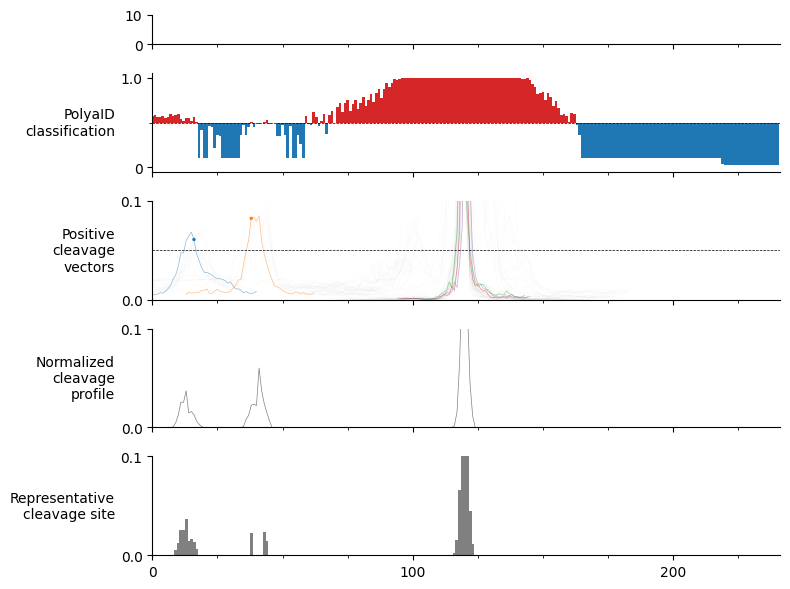

In [28]:
fig, axes = plt.subplots(5, 1, figsize=(8, 6), sharex=True,
                         gridspec_kw={'height_ratios':[0.3,1,1,1,1]})

_ = cleavage_profile_explanation2(
    axes, region, inputs, reads_dict, genome,
    visible_region=(0, n), visible_labels='absolute',
    cutoff_class=0.5, cutoff_clv=0.05, normalize=True,
    ylims_3reads=(0,10), ylims_clv=(0,0.1), ylims_pro=(0,0.1),
)

axes[1].set_ylabel("PolyaID\nclassification",       rotation=0, ha='right', va='center')
axes[2].set_ylabel("Positive\ncleavage\nvectors",   rotation=0, ha='right', va='center')
axes[3].set_ylabel("Normalized\ncleavage\nprofile", rotation=0, ha='right', va='center')
axes[4].set_ylabel("Representative\ncleavage site", rotation=0, ha='right', va='center')

plt.tight_layout()
plt.savefig(OUTDIR / "cleavage_profile_explanation.example.svg", dpi=600, transparent=True)
plt.show()
